# Heartbeat Sounds Classification using Machine Learning
DSI 13 Capstone Project: Classifying heartbeat anomalies from recorded audio

**Notebook 1: EDA**

# Problem Statement:
Stethoscope is good in detecting the first warning signs of heart disease. However, this is always done by frontline health workers, mostly when we are sick or during our annual physical examination. Although digital stethoscopes is available but we still need healthcare professional to determine whether an individual is having hearbeat irregularities or abnormalities and need for further check-up. 
It is well known that early detection and intervention in heart disease (or any disease) will greatly imporves the lifespan and the effectiveness of treatment options. 

The **goal** of this project is to use machine learning methods to identify and **classify heartbeat sounds** from audio collected from stethoscopes into normal versus various non-normal heartbeat sounds.


### Target Audience:
1. Untrained frontline healthcare workers to help determine whether an individual should reffered to expert diagnosis.
2. Consumer who can frequently check their respiratory health or constantly monitor if there is an heartbeat irregularities and prompt them to seek treatment in early stage. 

### Success Metric
Model selections: Supervised Classification: CNN (convolutional neural network), XGBOOST

Evaluation metric: Precision, f1, Accuracy

### Data Source
This is kaggle data science problem. The scope of this project constraint to challenge 2, which details and its data source can be found in below link:

[kaggle dataset: Heartbeat Sounds](https://www.kaggle.com/kinguistics/heartbeat-sounds)

## Importing Libraries

In [ ]:
### install librosa if you do not have this library
#!pip install librosa

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.signal import welch

## audio
import librosa as lr
from librosa import display
import wave                    # library handles the parsing of WAV file headers
import pywt
import IPython.display as ipd  #audio playback

## plot
import matplotlib.pyplot as plt
import seaborn as sns

## others
from glob import glob
import itertools
import os
from IPython.display import Image

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Goal: Heart Sound Classification

To address the problem statement, my goal is to produce a method that can **classify the unlabeled real heart audio** (also known as “beat classification”) into the correct categories after training on both dataset A and dataset B.

|Dataset|Number of Categories|Categories|Sources|Recorded by|
|---|---|---|---|---|
|A|4|Normal, Murmur, Extra Heart Sound, Artifact|general public|iStethoscope Pro iPhone app|
|B|3|Normal, Murmur, Extrsystole|clinic trial in hospitals|digital stethoscope|

- audio files - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

# 1 Exploratory Data Analysis (EDA)
- Loading given datasets (csv)
- Distribution of categories (label/ class)
- Audio files EDA

## Given datasets 
- two sets of wav files (set_a, set_b)
- three csv files (set_a, set_b, and set_a_timing)

In [2]:
ls ../datasets/challenge2/

set_a/            set_a_timing.csv* set_b.csv*
set_a.csv*        set_b/


both set_a and set_b includes both labeled audio and unlabeled audio


In [3]:
ls ../datasets/challenge2/set_a/

Aunlabelledtest__201012172010.wav* artifact__201106211430.wav*
Aunlabelledtest__201101051105.wav* artifact__201106212112.wav*
Aunlabelledtest__201101061552.wav* artifact__201106220340.wav*
Aunlabelledtest__201101091156.wav* artifact__201106221254.wav*
Aunlabelledtest__201101110659.wav* extrahls__201101070953.wav*
Aunlabelledtest__201101152256.wav* extrahls__201101091153.wav*
Aunlabelledtest__201101220549.wav* extrahls__201101152255.wav*
Aunlabelledtest__201101241434.wav* extrahls__201101160804.wav*
Aunlabelledtest__201102081033.wav* extrahls__201101160808.wav*
Aunlabelledtest__201102081045.wav* extrahls__201101161027.wav*
Aunlabelledtest__201102200848.wav* extrahls__201101241423.wav*
Aunlabelledtest__201103011036.wav* extrahls__201101241433.wav*
Aunlabelledtest__201103140236.wav* extrahls__201102070251.wav*
Aunlabelledtest__201103170122.wav* extrahls__201102071835.wav*
Aunlabelledtest__201103200518.wav* extrahls__201102241217.wav*
Aunlabelledtest__201103201314.wav* extrahls__2011031501

## 1.1 Loading CSV files and EDA

Explore the information provided by the 3 csv files

In [4]:
## load and explore set_a
set_a = pd.read_csv('../datasets/challenge2/set_a.csv')
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [5]:
### 4 columns in set a, with all null value in 'sublabel' column
set_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   176 non-null    object 
 1   fname     176 non-null    object 
 2   label     124 non-null    object 
 3   sublabel  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


In [6]:
### there are 52 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category
set_a.isnull().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [7]:
### There are 4 categories in set_a: artifact, extrahls, murmur, and normal heartbeat
set_a['label'].unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

In [8]:
## load and explore set_b
set_b = pd.read_csv('../datasets/challenge2/set_b.csv')
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [9]:
### Similarly, 4 columns in set a, there are some info in 'sublabel' column (it is all null in set_a)
set_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dataset   656 non-null    object
 1   fname     656 non-null    object
 2   label     461 non-null    object
 3   sublabel  149 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In [10]:
### there are 195 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category

set_b.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

In [11]:
### There are 3 categories in set_a: extrastole, murmur, and normal heartbeat
set_b['label'].unique()

array(['extrastole', 'murmur', 'normal', nan], dtype=object)

**`sublabel`** column

This column label those wav with extra amount of background noise.

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

Dataset B contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. You may choose to use this or ignore it. However the test set will include some equally noisy examples.

In [12]:
### some of the wav file from 'murmur' or 'normal' categories have extra background noise
set_b['sublabel'].unique()

array([nan, 'noisymurmur', 'noisynormal'], dtype=object)

In [13]:
### load and explore set_a_timing
### this csv file contains 21 wav file with their S1 & S2 location in the wavv.
### this is mainly used for kaggle problem challenge 1, which will not be used in this project.
timing = pd.read_csv('../datasets/challenge2/set_a_timing.csv')

print(f' number of unique fname: {timing.fname.nunique()}')
timing.head()

 number of unique fname: 21


fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992

In [14]:
### no null avlue in this csv file
timing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fname     390 non-null    object
 1   cycle     390 non-null    int64 
 2   sound     390 non-null    object
 3   location  390 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.3+ KB


### Combine set_a & set_b csv files

There are total of 832 wav files, with **585** labeled (training set), and **247** unlabeled (test set).

**351** out of 585 labeled wav files are from `normal` category.

In [15]:
set_ab = pd.concat([set_a, set_b])
set_ab.describe()

dataset                                           fname   label  \
count      832                                             832     585   
unique       2                                             832       5   
top          b  set_b/Btraining_normal_250_1309202496494_B.wav  normal   
freq       656                                               1     351   

           sublabel  
count           149  
unique            2  
top     noisynormal  
freq            120

In [16]:
set_ab.isnull().sum()

dataset       0
fname         0
label       247
sublabel    683
dtype: int64

## 1.2 Distribution of the heartbeat audio per category

- `normal` heartbeat category is the majority class, with 351 out of total 585 (60%)
- `extrahls` heartbeat category is the minority class, with only 19 (3.2%)
- This is imbalanced multi-class classification problem

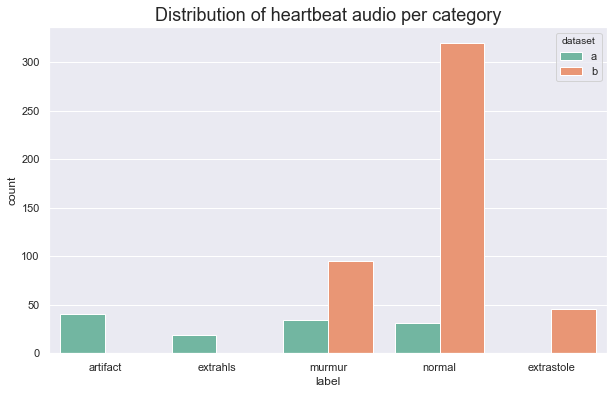

In [17]:
sns.set(style="darkgrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(x='label', hue = 'dataset', data = set_ab, palette="Set2");
ax.set_title('Distribution of heartbeat audio per category', fontsize = 18);

In [18]:
### Get the count number per category
set_ab.groupby('label')['fname'].count()

label
artifact       40
extrahls       19
extrastole     46
murmur        129
normal        351
Name: fname, dtype: int64

In [19]:
### Percentage per category
round(set_ab.groupby('label')['dataset'].count()/585*100, 1)

label
artifact       6.8
extrahls       3.2
extrastole     7.9
murmur        22.1
normal        60.0
Name: dataset, dtype: float64

## 1.3 Audio files EDA

### Compile list of audio wav files in set_a and set_b folders

use `glob()` to return a list of audio wav files that match the wav files' name in folder that store them.

In [20]:
### set_a folder
wav_dir_set_a = '../datasets/challenge2/set_a/'
a_wav = glob(wav_dir_set_a + '/*.wav')
print(f'Total wav file in set_a folder :{len(a_wav)}')

Total wav file in set_a folder :176


In [33]:
### set_b folder:
wav_dir_set_b = '../datasets/challenge2/set_b/'
b_wav = glob(wav_dir_set_b + '/*.wav')
print(f'Total wav file in set_b folder :{len(b_wav)}')

Total wav file in set_b folder :656


### Getting basic information on the audio wav files

In both set_a and set_b folders, they consist of heartbeat sounds from different categories and stored as **WAV** files.

In general, uncompressed audio is stored as a sequence of numbers that indicate the amplitude of the recorded sound pressure at each time point. In the WAV standard, these numbers are packed into a bytestring. The interpretation of this bytestring depends primarily on two factors: 
1. Sampling rate (framerate), usually given in Hertz, which indicates how many number samples comprise in one second's worth of data. 
2. Bit depth (sample width), number of bytes per sample.

On top of the two listed above, WAV file parameters include number of channels. Typically, they have 1 (mono) or 2 (for stereo). The data of a WAV file is given as a sequence of frames. A frame consists of samples. There is one sample per channel, per frame. Every wav file has a sample width, or, the number of bytes per sample. Typically this is either 1 or 2 bytes.

The `wave` library handles the parsing of WAV file headers, which include the parameters mentioned above. 

**set_a**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 44.1kHz

**set_b**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 4kHz

In [22]:
### set_a
f = wave.open(a_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=349958, comptype='NONE', compname='not compressed')

In [30]:
### set_b
f = wave.open(b_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=16188, comptype='NONE', compname='not compressed')

### Separate label and unlabel audio wav into different datasets

Compile the labeled audio wav files from set_a and set_b folders

In [27]:
### set_a
dataset_a, aunlabel = [], []

for file in a_wav:
    label = os.path.basename(file).split("__")[0] #normal__20xxx.wav, label is the first item after split
    filename = os.path.basename(file).split("__")[1]
    filepath = file
    dur = lr.get_duration(filename = file)
    # compile label wav
    if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
        dataset_a.append({'filename': filename,
                          'label' : label,
                          'wav_duration' : dur,
                          'file_path' : filepath,
                          'folder' : 'a' })
    # compile unlable wav
    else:
        aunlabel.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'file_path': filepath,
                         'folder': 'a'})

In [35]:
### set_b
dataset_b, bunlabel = [], []

for file in (b_wav):
    label = os.path.basename(file).split("__")[0] 
    filename = os.path.basename(file).split("__")[1] 
    filepath = file
    dur = lr.get_duration(filename = file)
    # drop unlabeled wav
    if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
        dataset_b.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'file_path': filepath,
                         'folder': 'b'})
    else:
        bunlabel.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'file_path': filepath,
                         'folder': 'b'})

In [36]:
### convert dataset_a & dataset_b into dataframe
df_a = pd.DataFrame(dataset_a)
df_b = pd.DataFrame(dataset_b)
df_aunlabel = pd.DataFrame(aunlabel)
df_bunlabel = pd.DataFrame(bunlabel)
print(f'df_a : {df_a.shape}')
print(f'df_b : {df_b.shape}')
print(f'df_aunlabel : {df_aunlabel.shape}')
print(f'df_bunlabel : {df_bunlabel.shape}')

df_a : (124, 5)
df_b : (461, 5)
df_aunlabel : (52, 5)
df_bunlabel : (195, 5)


In [37]:
### combine dataset_a & dataset_b
df_ab = pd.concat([df_a, df_b], ignore_index= True)
print(f" df_ab : {df_ab.shape}")

 df_ab : (585, 5)


### Match the filename in given xlsx from Kaggle to unlabel dataset

Kaggle provide an excel sheet that we need to key in the predicted results on the unlabeled audio wav.
Thus, I would like to first, extract the index in that excel sheet to the compiled unlable dataframe

In [38]:
### read from .xlsx, extract the wav file name (exclude the .aif)

### set_a, in xlsx sheen 'Dataset A'
kag_eval_a = pd.read_excel('../datasets/Evaluation/Challenge2_evaluation_sheet.xlsx',
                           usecols = ['Dataset A'],
                           sheet_name = 'Dataset A')
kag_eval_a = kag_eval_a.loc[:51, 'Dataset A']
kag_eval_a = [name.split('.')[0] for name in kag_eval_a]


### set_b, in xlsx sheen 'Dataset B'
kag_eval_b = pd.read_excel('../datasets/Evaluation/Challenge2_evaluation_sheet.xlsx',
                           usecols = ['Dataset B'],
                           sheet_name = 'Dataset B')
kag_eval_b = kag_eval_b.loc[:194, 'Dataset B']
kag_eval_b = [name.split('.')[0] for name in kag_eval_b]

In [39]:
### match the idx into unlabel dataframe for set a & set b
indices_a, indices_b = [], []

### set a
for i in range(df_aunlabel.shape[0]):
    name = df_aunlabel['filename'][i].split('.')[0]
    idx = [j for j,s in enumerate(kag_eval_a) if name == s]
    indices_a.append(idx[0])
    
df_aunlabel['idx'] = indices_a

### set b
for i in range(df_bunlabel.shape[0]):
    name = df_bunlabel['filename'][i].split('.')[0]
    print(name, i)
    for j, s in enumerate(kag_eval_b):
        if name == s:
            indices_b.append(j)
            print (j)

195_1308140095331_D 0
124
187_1308073994223_C 1
116
103_1305031931979_C 2
4
123_1306331925797_A 3
28
110_1305655332337_D 4
16
191_1308077299430_D 5
120
159_1307018640315_A 6
81
142_1306763049574_C 7
53
243_1309197760898_D 8
160
287_1311170903290_D 9
184
237_1308750231222_C1 10
155
294_1311681084248_D 11
189
161_1307101199321_D 12
85
113_1306244002866_C 13
18
154_1306935608852_A 14
71
159_1307018640315_C 15
83
203_1308162026258_C 16
130
118_1306262335509_C2 17
24
163_1307104470471_D 18
89
220_1308250132896_A 19
145
145_1307987561278_D 20
57
136_1306429977501_D 21
44
103_1305031931979_A 22
3
245_1309200438094_C 23
162
128_1306344005749_C 24
34
159_1307018640315_B 25
82
210_1308162935880_D 26
136
232_1308748524018_D 27
152
193_1308078104592_D 28
122
202_1308145175747_B 29
129
134_1306428161797_B 30
41
282_1311166081161_D 31
181
154_1306935608852_D 32
73
235_1308749032454_D1 33
154
191_1308077299430_C 34
119
108_1305654420093_C 35
11
137_1306764999211_B1 36
46
270_1309369533040_D 37
173
14

In [40]:
### There are missing 1 idx in indices_b, meaning, 1 filename in d_bunlabel does not match with
print(f"len : {len(indices_b)}")

### the mis-match is idx = 112
### insert '112' in indices_b at position [50]. ASSUMPTION, they are the same
indices_b.insert(50,112)
print(f"len update : {len(indices_b)}")

## update df_bunlabel with idx column
### 2nd gridserch on the 3rd convolutional layer
df_bunlabel['idx'] = indices_b

len : 194
len update : 195


In [41]:
### Rearange the df_aunlabel and df_bunlabel according to the 'idx'
### So that it is easy to paste the prediciton after modeling to the kaggle excelsheet 
### to evaluate how well the model predict (kaggle has the calculation to eval it that log inside the excelsheet)

### set 'idx' as index
df_aunlabel_sorted = df_aunlabel.set_index(df_aunlabel.idx)
df_bunlabel_sorted = df_bunlabel.set_index(df_bunlabel.idx)

### sort index in ascending order (this step will get the list order same as kaggle excelsheet list)
df_aunlabel_sorted.sort_index(inplace = True)
df_bunlabel_sorted.sort_index(inplace = True)

### drop 'idx' column
df_aunlabel_sorted.drop(columns = ['idx'], inplace = True)
df_bunlabel_sorted.drop(columns = ['idx'], inplace = True)

### 1.3.1 Defining plot function for visualization of audio wav file in time and frequency domain

**LibROSA** is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa.load()` function returns 2 things:
- numpy array of amplitudes
- sampling rate (if keep the argument `sr = None`, it will load the audio file in its original sampling rate, else it will use its default sampling rate of `22050`)


In [42]:
### Define function to plot the audio in time domain
### This function return: 1) audio_data in array, 2) sampling rate, 
### 3) duration of audio wav, 4) plot the audio data in time domain

def time_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)   # librosa default sampling rate: 22050Hz
    
    plt.figure(figsize = (14,6))
    lr.display.waveplot(data, sr = sfreq);
    
    plt.xlabel('Time, s', fontsize=14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    
    audio_data = data
    sampling_frequency = sfreq
    dur = lr.get_duration(data)
    return audio_data, sampling_frequency, dur

In [43]:
### Define function to plot the audio in frequency domain

def fft_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    #check if the len of audio data is odd number
    n = len(data)
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
   
    t = 1/sfreq
    yf = scipy.fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)    #frequency
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency, Hz', fontsize = 14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    plt.grid()

    ax.set_xscale('log')    #set frequency axis in log scale
    ax.set_xlim(1, 1000)
    ax.set_ylim(0, 0.05)
    
    
    return plt.show()

## 1.3.2 Heartbeat audio for all categories at a glance

- First column are heartbeat sound form set_a
- Second column are heartbeat sound from set_b

From a visual inspection it is not easy to visualize the difference between some of the categories of heartbeat sound, particularly those with more background noise (set_b). 

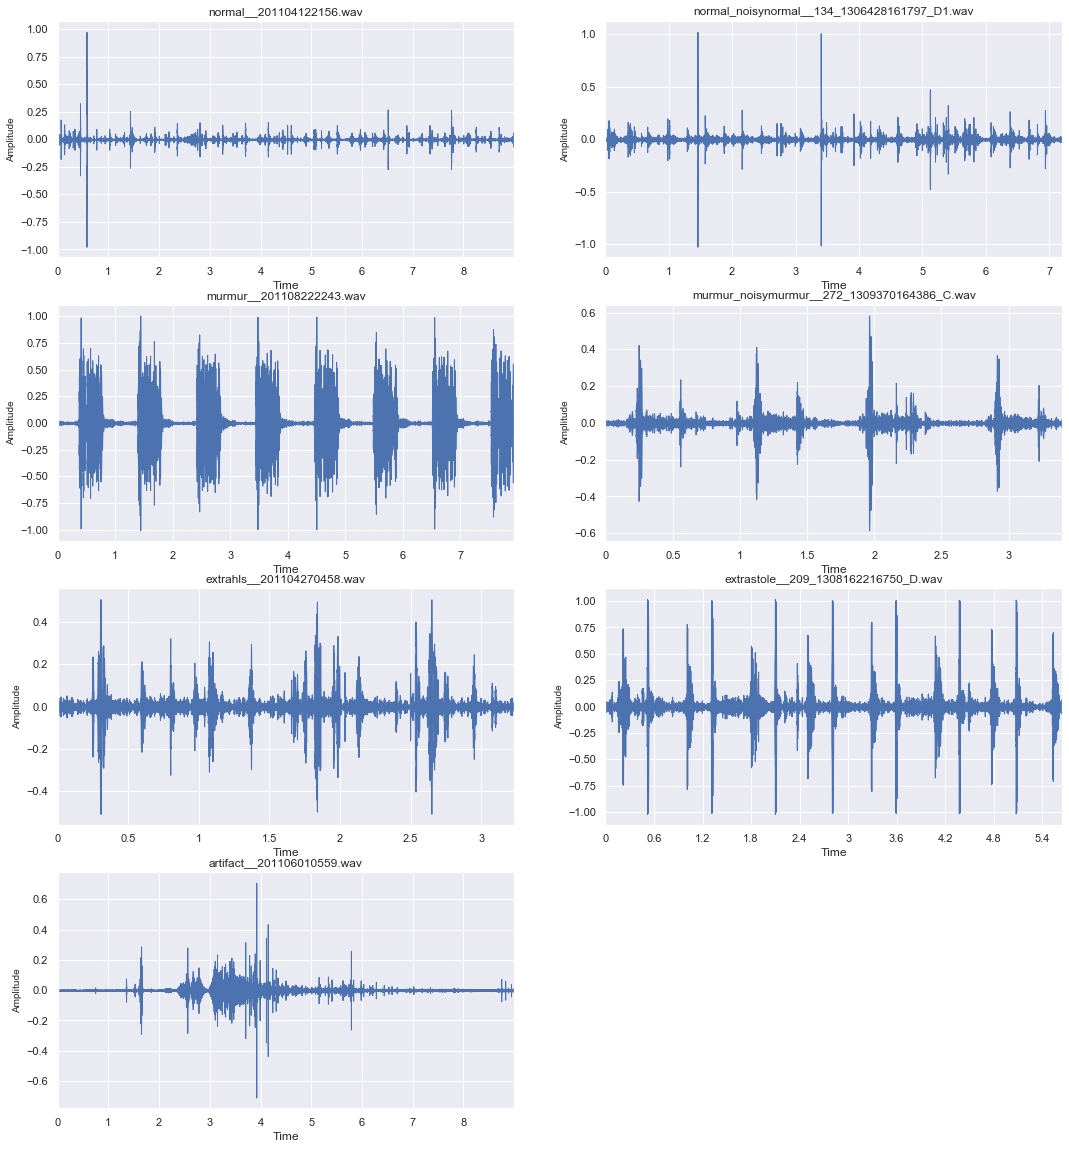

In [44]:
### Visualize all categories of heartbeat sound provided

select = [a_wav[14], b_wav[3], a_wav[11], b_wav[7], a_wav[18], b_wav[20], a_wav[10]]

fig = plt.subplots(figsize = (18,20))

for i in range(1,8):
    subplot(4,2,i)
    data, sr = lr.load(select[i-1], res_type='kaiser_fast')
    lr.display.waveplot(data, sr)
    
    plt.ylabel('Amplitude', fontsize =10)
    plt.title(select[i-1][29:], fontsize =12)


## 1.3.3 Normal heartbeat audio

**Normal Category of heartbeat**
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute). Note the temporal description of “lub” and “dub” locations over time in the following illustration:

…lub……….dub……………. lub……….dub……………. lub……….dub……………. lub……….dub…

In medicine we call the **lub** sound "**S1**" and the **dub** sound "**S2**". Most normal heart rates at rest will be between about 60 and 100 beats (‘lub dub’s) per minute. However, note that since the data may have been collected from children or adults in calm or excited states, the heart rates in the data may vary from 40 to 140 beats or higher per minute. Dataset B also contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. 

Duration of audio wav file: 7.94 sec


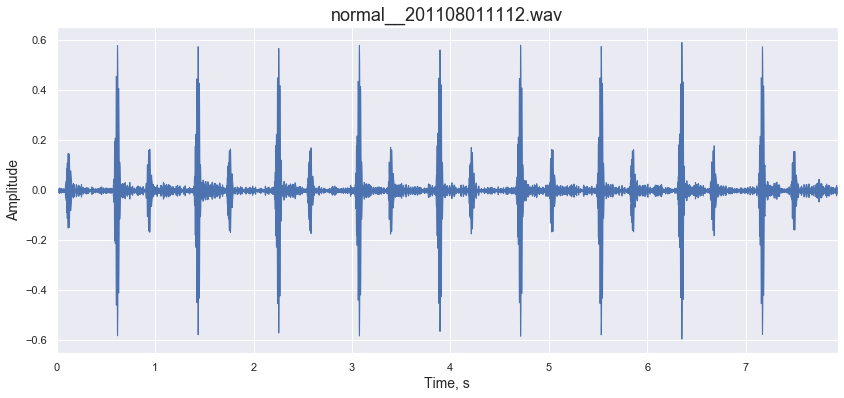

In [45]:
### Plot audio from a_wav[0]
data, sfreq, dur = time_plot(a_wav[0])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [46]:
### Listen to the audio from a_wav[0]
ipd.Audio(a_wav[0])

Visual inpection on the audio in **frequency domain**

The frequency spectrum shown in below graph observed that:
- the heart beat sound is at around 60Hz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


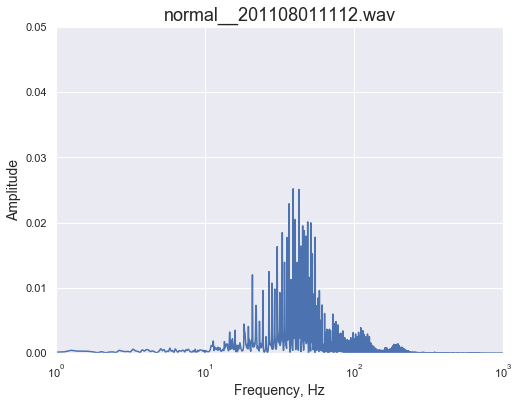

In [47]:
fft_plot(a_wav[0])

### 1.3.4 Murmur heartbeat audio

Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub. Below, you can find `''''` at the locations a murmur may be.

…lub..`''''`...dub……………. lub..`''''`..dub ……………. lub..`''''`..dub ……………. lub..`''''`..dub …

or

…lub……….dub…`''''''`….lub………. dub…`''''''`….lub ………. dub…`''''''`….lub ……….dub…

Dataset B also contains noisy_murmur data - murmur data which includes a substantial amount of background noise or distortion.

Duration of audio wav file: 7.94 sec


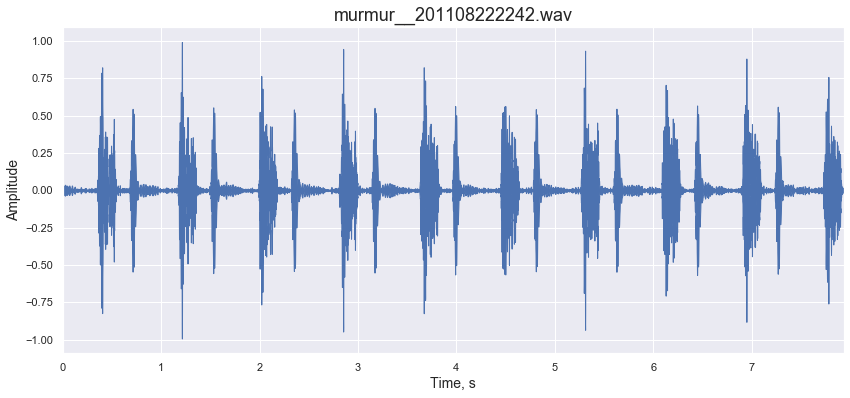

In [48]:
### Plot audio from a_wav[9]
data, sfreq, dur = time_plot(a_wav[9])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [49]:
ipd.Audio(a_wav[9])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at around 60Hz.
- murmurs heard after S1 (lub), and at around 300Hz, the smaller peak in the fft plot shown below.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


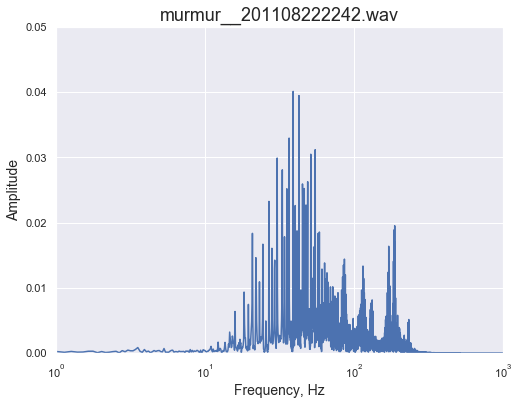

In [50]:
fft_plot(a_wav[9])

### 1.3.5 Extra Heart Sound (set_a only)

Extra heart sounds can be identified because there is an additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”. An extra heart sound may not be a sign of disease.  However, in some situations it is an important sign of disease, which if detected early could help a person.  The extra heart sound is important to be able to detect as it cannot be detected by ultrasound very well. Below, note the temporal description of the extra heart sounds:

…lub.lub……….dub………..………. lub. lub……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub.dub………………….lub.……….dub.dub………………….lub……..…….dub. dub……

Duration of audio wav file: 7.88 sec


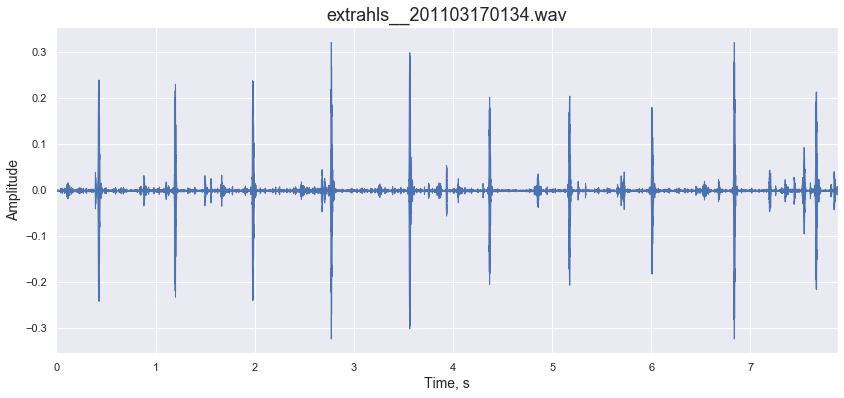

In [51]:
### Plot audio from a_wav[5]
data, sfreq, dur = time_plot(a_wav[5])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [52]:
ipd.Audio(a_wav[5])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 200-300Hz.
- extra S2 (dub) heard after S2, which in above time series plot, there are >1 small peak after the big peak.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


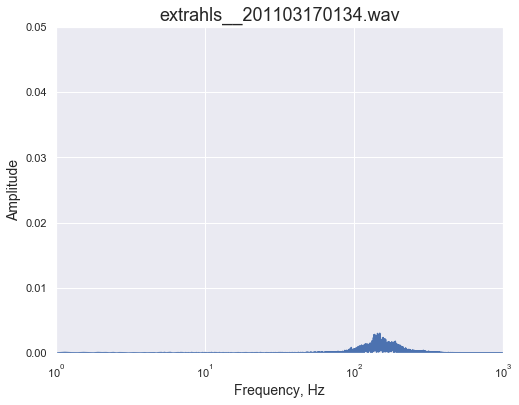

In [53]:
fft_plot(a_wav[5])

### 1.3.6 Artifact Category (set_a only)

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.

Duration of audio wav file: 9.0 sec


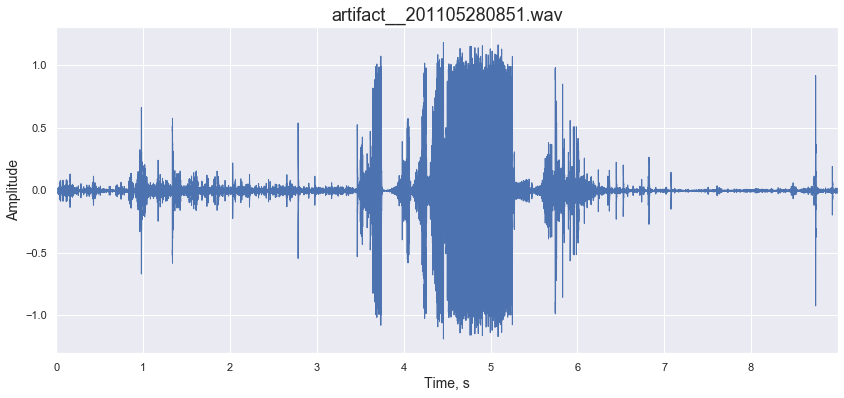

In [54]:
### Plot audio from a_wav[7]
data, sfreq, dur = time_plot(a_wav[7])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [55]:
ipd.Audio(a_wav[7])

Visual inpection on the audio in both frequency domain and time domain:
- there are barely heart sound heard, mainly with various type of noise. No periodic signal observed in time domain and the frequency spread from low frequency up to beyond 1kHz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


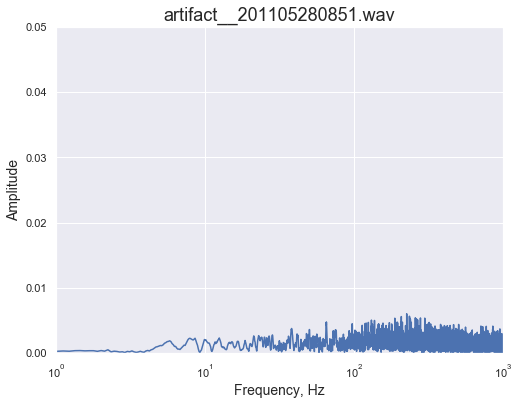

In [56]:
fft_plot(a_wav[7])

### 1.3.7 EDA on Extrasystole (set_b only)

Extrasystole sounds **may appear occasionally** and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. Below, note the temporal description of the extra heart sounds:

…........lub……….dub………..………. lub. ………..……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub......………………….lub.…………………dub.dub………………….lub……..…….dub.……

Duration of audio wav file: 5.64 sec


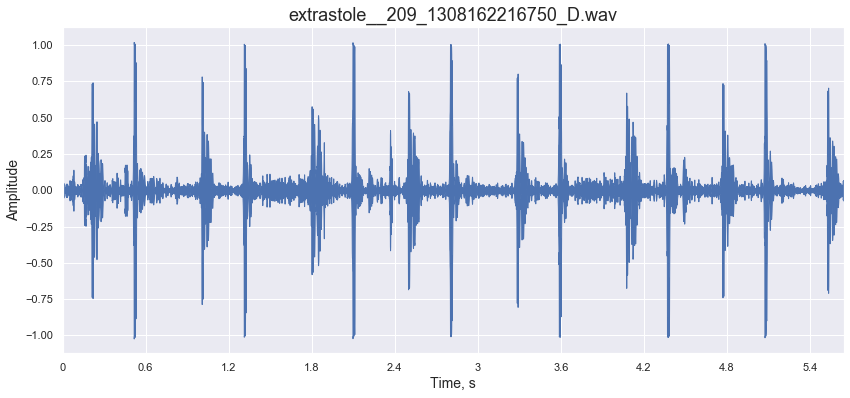

In [57]:
### Plot audio from b_wav[20]
data, sfreq, dur = time_plot(b_wav[20])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [58]:
ipd.Audio(b_wav[20])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 80Hz.
- it is not easy to hear the extrasystole sounds, it seems appeared at around 2.4s in the tim-series plot

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


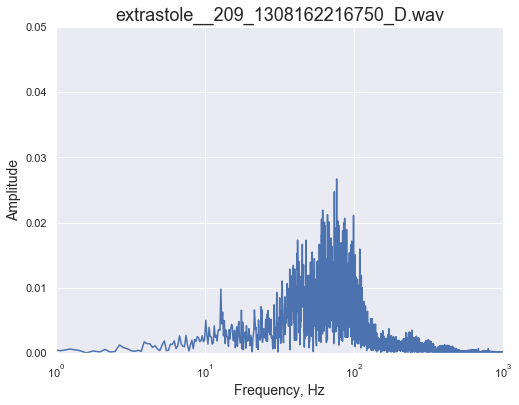

In [59]:
fft_plot(b_wav[20])

### Export dataset to csv

In [60]:
df_a.to_csv('../outputs/df_a.csv', index = False)
df_b.to_csv('../outputs/df_b.csv', index = False)
df_ab.to_csv('../outputs/df_ab.csv', index = False)

### unlabel dataset(sorted according to kaggle excelsheet)
df_aunlabel.to_csv('../outputs/df_aunlabel.csv', index = False)
df_bunlabel.to_csv('../outputs/df_bunlabel.csv', index = False)

### unlabel dataset(sorted according to kaggle excelsheet)
df_aunlabel_sorted.to_csv("../outputs/df_aunlabel_sorted.csv", index = False)
df_bunlabel_sorted.to_csv("../outputs/df_bunlabel_sorted.csv", index = False)

**proceed to notebook 2 for dat pre-processing and feature extraction**